In [ ]:
##### Flip to get 16 images for each category #####
# from PIL import Image, ImageOps
# for i in range(1,9):
#     # print(i)
#     im = Image.open(f'data/kaggle/muffin/muffin-{i}.jpeg')
#     im_mirror = ImageOps.mirror(im)
#     im_mirror.save(f'data/kaggle/muffin/muffin-{i+8}.jpeg', quality=100)


# Now there are 16 images of Chihuahua and 16 images of Muffin, half of which are mirror of another.

In [41]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F

from sklearn.model_selection import KFold
import numpy as np

# Allow augmentation transform for training set, no augementation for val/test set
# Normalize(mean, std, inplace=False)
# mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])


full_train_dataset = torchvision.datasets.ImageFolder('data/kaggle', transform=preprocess_augment)
index = np.arange(16)
kf = KFold(n_splits = 8, shuffle=True, random_state=0)
iterator = kf.split(index)

BATCH_SIZE=4
NUM_WORKERS=2
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
train_index, val_index = iterator.__next__()
# train_index, val_index = iterator.__next__()
print(np.append(train_index,train_index+16), np.append(val_index, val_index+16))
train_dataset = torch.utils.data.Subset(full_train_dataset, np.append(train_index,train_index+16))
train_dataset.transform = preprocess_augment
val_dataset = torch.utils.data.Subset(full_train_dataset, np.append(val_index, val_index+16))
val_dataset.transform = preprocess
# test_dataset = torchvision.datasets.ImageFolder('data/test', transform=preprocess)
# print(test_dataset)
# test_dataloader   = torch.utils.data.DataLoader(test_dataset  , batch_size=BATCH_SIZE,shuffle=False, num_workers=NUM_WORKERS)
# train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [1600, 1988-1600])
# DataLoaders for the three datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)
val_dataloader   = torch.utils.data.DataLoader(val_dataset  , batch_size=BATCH_SIZE,shuffle=False, num_workers=NUM_WORKERS)



[ 0  1  2  3  4  6  7  8  9 10 11 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 29 30 31] [ 5 12 21 28]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor([0, 0, 1, 1])


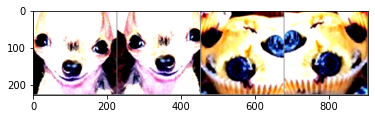

tensor([0, 0, 1, 1]) ['chihuahua' 'chihuahua' 'muffin' 'muffin']


In [42]:
import matplotlib.pyplot as plt
import numpy as np
# get some random training images
dataiter = iter(val_dataloader)
images, labels = dataiter.next()
print(labels)
toshow = torchvision.utils.make_grid(images)
toshow = toshow / 2 + 0.5     # unnormalize
npimg = toshow.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
classes = np.array(['chihuahua','muffin'])
print(labels, classes[labels])

In [36]:
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

from myNetwork.myResNet import ResNet
from trainer import trainer

def SEResNet18(num_classes = 10):
    return ResNet(ResNet._BLOCK_SEBASIC, [2, 2, 2, 2], num_classes)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
model = SEResNet18()
model.load_state_dict(torch.load('result-20210129-104338/seresnet18_adam_0.01.pth'))
model.classifier[2] = nn.Linear(512,2)
model.eval()


cuda:1


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): SEBasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (se): SELayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=64, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_feat

In [37]:
model.to(device)
criterion = nn.CrossEntropyLoss()
params_to_update = model.parameters()
# Now we'll use Adam optimization
optimizer = optim.Adam(params_to_update, lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=5)
t = trainer(device,criterion, optimizer,scheduler)
model = t.train(model, dataloaders, num_epochs=20, weights_name='seresnet18_chihuahua_muffin_adam_kaggle_0.01')

Epoch 0/59:LR: 0.01
----------
train Loss: 0.6986 Acc: 0.4643
Epoch time taken:  0.3322310447692871
val Loss: 0.6458 Acc: 0.5000
Epoch time taken:  0.5446250438690186
Epoch 1/59:LR: 0.01
----------
train Loss: 0.6547 Acc: 0.7500
Epoch time taken:  0.3120534420013428
val Loss: 0.6076 Acc: 1.0000
Epoch time taken:  0.47829174995422363
Epoch 2/59:LR: 0.01
----------
train Loss: 0.5927 Acc: 0.9643
Epoch time taken:  0.28942322731018066
val Loss: 0.4902 Acc: 1.0000
Epoch time taken:  0.44878268241882324
Epoch 3/59:LR: 0.01
----------
train Loss: 0.4943 Acc: 1.0000
Epoch time taken:  0.31403326988220215
val Loss: 0.4100 Acc: 1.0000
Epoch time taken:  0.46996617317199707
Epoch 4/59:LR: 0.01
----------
train Loss: 0.3849 Acc: 0.9643
Epoch time taken:  0.2659127712249756
val Loss: 0.2276 Acc: 1.0000
Epoch time taken:  0.4172227382659912
Epoch 5/59:LR: 0.01
----------
train Loss: 0.2690 Acc: 0.9286
Epoch time taken:  0.2723102569580078
val Loss: 0.1150 Acc: 1.0000
Epoch time taken:  0.4232754707